# Exercise: Retail Inventory and Sales Analysis

## Background:
You are a data analyst in a retail company that manages a large inventory of various products and records sales transactions across multiple locations. Your task is to analyze the company's inventory and sales data to identify trends, inefficiencies, and opportunities for improvement.

## Data:
You are provided with two CSV files:
- `inventory_data.csv` - This file contains information about the inventory, including product IDs, descriptions, prices, and quantities in stock.
- `sales_transactions.csv` - This file records sales transactions, including transaction IDs, dates, product IDs, quantities sold, and store locations.

## Tasks:

###  [1- Loading and Cleaning the Data:](#section1)

1. Read both CSV files into DataFrames using pandas.
2. Identify and handle missing values, inconsistencies, and outliers in the data.


### [ 2- SQL Integration:](#section2)
1. Import the cleaned data into a SQL database (you can use SQLite, PostgreSQL, etc.).
2. Perform SQL queries to further clean and prepare the data for analysis.

### [3- Inventory Analysis:](#section3)
1. Identify products with low stock levels and suggest reordering quantities.
2. Calculate the total value of inventory on hand for each product category.

### [4- Sales Analysis:](#section4)
1. Analyze sales trends over time and identify peak sales periods.
2. Determine the best-selling products and their contribution to overall sales.

### [ 5- Store Performance:](#section5)
1. Evaluate the sales performance of each store location.
2. Identify any stores with significantly different sales patterns.

###  [6- Visualization and Conclusions:](#section6)
1. Create visualizations to represent sales trends, inventory levels, and store performances.
2. Use charts and graphs that effectively communicate your findings.

### Insights and Recommendations:
1. Write a report summarizing your findings and analysis.
2. Provide actionable recommendations for inventory management and sales strategies.


In [664]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns 
from sqlalchemy import create_engine

import numpy as np
from scipy.stats import linregress

<a id="section1"></a>
## Step 1: Data Loading and Column Cleanup
- Load CSV into pandas DataFrame.
- Clean and rename column names.
- Focus on pandas skill enhancement.


In [665]:
#------------------------inventory_data--------------- CLEAN UP USING PANDAS--------------------------------------------------

# Load the CSV file into a DataFrame
inventory_df = pd.read_csv('DataSet/inventory_data.csv')

#Renaming columns 
inventory_df.rename(columns={"ProductID": "Product_ID", "Categ@@ry": "Category", "Pr!ce":"Price", "Quantity_in_Stock":"Stock"},inplace=True)

# Checking rows for missing values 
missing_val1 = inventory_df[inventory_df.isnull().any(axis=1)]
# print(missing_val) #Checking the missing values and also the nr of them so I can evaluate if its worth changing them or I should drop those records
# print(len(missing_val))


missing_per_col = inventory_df.isnull().sum() #Checking mising values per each col
print(missing_per_col)


# Calculating the mean(avg) price for each category and  adding the mean price of category for the missing price values
# Also assuming that empty records on Stock columns implies there is  0 stock of that product
category_mean_price = inventory_df.groupby('Category')['Price'].mean()

for category in category_mean_price.index: ##.loc[] locates records based on condition, its now selecting 'Price' based on 2 condition
    inventory_df.loc[(inventory_df['Category'] == category) & (inventory_df['Price'].isnull()), 'Price'] = category_mean_price[category]

inventory_df['Stock'].fillna(0, inplace=True)



inventory_df.head(5)

Product_ID      0
Category        0
Description     0
Price          20
Stock          15
dtype: int64


,Product_ID,Category,Description,Price,Stock
0,1,Toys & Games,Fashion-Wear 1,278.918617,39.0
1,2,Sports & Outdoors,Kitchen-Tool 2,360.442790,28.0
2,3,Toys & Games,Sports-Gear 3,305.354054,24.0
3,4,Clothing,Toy-Item 4,276.992760,18.0
4,5,Electronics,Electro-Gadget 5,217.590852,67.0


In [666]:
#-----------------------sales_transactions---- CLEAN UP USING PANDAS --------------------------------------------------


sales_df = pd.read_csv('DataSet/sales_transactions.csv')
#Renaming columns for unifrom access 
sales_df.rename(columns={"TransactionID": "Transaction_ID", "ProductID": "Product_ID", }, inplace=True)

#Checking for missing values 
missing_val2 = sales_df[sales_df.isnull().any(axis=1)]
# print(missing_val2, f" Number of missing values: {len(missing_val2)}")

#Checking missing value per each column so I can decide how to move forward 
missing_values_per_column = sales_df.isnull().sum()
print(missing_values_per_column)

#I realized that the there are 30 records on Quantity_Sold columns missing from 40 in total, so I want to 
#investigate which location has the higest number of "Quantity Sold" missing records 
missing_values_per_store = missing_quantity_sold.groupby('Store_Location').size()
sorted_missing_values = missing_values_per_store.sort_values(ascending=False)
print(sorted_missing_values)


#Missing value on "Quantity_Sold" it will now be "Unknown", it is probarly a good idea to still keep the recrod since it has the other column recrods
sales_df["Store_Location"].fillna('Unknown', inplace=True)


#Missing value for "Quantity Sold", will be replaced with the mean Quantity Sold nr of each product ID 
sales_df['Quantity_Sold'] = sales_df.groupby('Product_ID')['Quantity_Sold'].transform(lambda x: x.fillna(np.floor(x.mean())))


sales_df.head(5)


Transaction_ID     0
Date               0
Product_ID         0
Quantity_Sold     30
Store_Location    10
dtype: int64
Store_Location
Airport Kiosk, Houston          9
Mall Branch, Chicago            8
Suburban Outlet, Los Angeles    5
Downtown Store, New York        4
Online Shop, Phoenix            4
dtype: int64


,Transaction_ID,Date,Product_ID,Quantity_Sold,Store_Location
0,1,2022-09-04,410,3.0,"Suburban Outlet, Los Angeles"
1,2,2022-08-11,119,5.0,"Downtown Store, New York"
2,3,2022-10-01,459,6.0,"Airport Kiosk, Houston"
3,4,2022-02-24,232,4.0,"Airport Kiosk, Houston"
4,5,2022-11-26,457,5.0,"Online Shop, Phoenix"


<a id="section2"></a>
# Step-2 Converting CSV Files to SQL Database for more advanced queries 

## Aim
The primary objective is to transform CSV data into a SQL database. This enables the execution of more sophisticated SQL queries, enhancing data analysis capabilities.


In [667]:
engine = create_engine('mysql+pymysql://root@localhost/retail_database')

inventory_df.to_sql('inventory_data', engine, if_exists='append', index=False)
sales_df.to_sql('sales_transactions', engine, if_exists='append', index=False)


IntegrityError: (pymysql.err.IntegrityError) (1062, "Duplicate entry '1' for key 'PRIMARY'")
[SQL: INSERT INTO inventory_data (`Product_ID`, `Category`, `Description`, `Price`, `Stock`) VALUES (%(Product_ID)s, %(Category)s, %(Description)s, %(Price)s, %(Stock)s)]
[parameters: ({'Product_ID': 1, 'Category': 'Toys & Games', 'Description': 'Fashion-Wear 1', 'Price': 278.9186169, 'Stock': 39.0}, {'Product_ID': 2, 'Category': 'Sports & Outdoors', 'Description': 'Kitchen-Tool 2', 'Price': 360.4427895, 'Stock': 28.0}, {'Product_ID': 3, 'Category': 'Toys & Games', 'Description': 'Sports-Gear 3', 'Price': 305.3540543, 'Stock': 24.0}, {'Product_ID': 4, 'Category': 'Clothing', 'Description': 'Toy-Item 4', 'Price': 276.9927597, 'Stock': 18.0}, {'Product_ID': 5, 'Category': 'Electronics', 'Description': 'Electro-Gadget 5', 'Price': 217.5908517, 'Stock': 67.0}, {'Product_ID': 6, 'Category': 'Home & Kitchen', 'Description': 'Fashion-Wear 6', 'Price': 326.4881154, 'Stock': 44.0}, {'Product_ID': 7, 'Category': 'Sports & Outdoors', 'Description': 'Kitchen-Tool 7', 'Price': 263.6686208692233, 'Stock': 83.0}, {'Product_ID': 8, 'Category': 'Electronics', 'Description': 'Sports-Gear 8', 'Price': 446.9687704, 'Stock': 45.0}  ... displaying 10 of 500 total bound parameter sets ...  {'Product_ID': 499, 'Category': 'Electronics', 'Description': 'Toy-Item 499', 'Price': 131.7225979, 'Stock': 58.0}, {'Product_ID': 500, 'Category': 'Clothing', 'Description': 'Electro-Gadget 500', 'Price': 243.96292304847825, 'Stock': 81.0})]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

In [ ]:
with engine.connect() as connection:
    
    inventory_df = pd.read_sql("SELECT * FROM inventory_data LIMIT 5", connection)
    sales_df = pd.read_sql("SELECT * FROM sales_transactions ORDER BY Date LIMIT 5", connection)

    # Display the DataFrames
    display(inventory_df)
    display(sales_df)


<a id="section3"></a>
# Step-3  Inventory Analysis:
1. Identify products with low stock levels and suggest reordering quantities.
2. Calculate the total value of inventory on hand for each product category.

In [668]:
with engine.connect() as connection:
    
    print("1)-------------PRODUCTS WITH STOCK LESS THAN 10 --------------")
    low_stock = pd.read_sql("""
    SELECT Product_ID,Category, Description as "Product Name", Stock
    FROM inventory_data
    WHERE Stock <= 10
    ORDER BY Stock ASC 
    """, connection)
    display(low_stock)
    
    
    
    
    print("2)-------------VALUE OF PRODUCTS IN STOCK PER EACH CATEGORY --------------")
    category_value_in_stock = pd.read_sql("""
    SELECT Category, SUM(Stock) as "Value of Stock"
    FROM inventory_data
    GROUP BY Category;
    """, connection)

    display(category_value_in_stock)
    
    
    ##I am adding another extra requriment, I will compare the stock levels against the sales per product and per category 
    #FIRST I will be finding  the sales per each  product in all stores, I have to perform an Left Join to get name of each product 
    #and to clearly see the stock level against the items sold
    
    print("3)-------------PRODUCTS SOLD DURING THIS YEAR AND CURRENT STOCK -------------")
    product_sales_stock = pd.read_sql("""
    SELECT i.Description as "Product_Name", SUM(s.Quantity_Sold) as Quantity_Sold, i.Stock
    FROM inventory_data as i
    LEFT JOIN sales_transactions as s ON i.Product_ID = s.Product_ID 
    GROUP BY s.Product_ID 
    ORDER BY Quantity_Sold DESC
    """, connection)
    display(product_sales_stock)
    
    #I will now compare the stock leveles against the sales per category, identifying the categories at risk 
    
    print("4)--------------CATEGORY SALES COMPARED WITH  THE STOCK LEVEL OF THE THAT CATEGORY --------------------------")
    
    
    category_sales_stock = pd.read_sql("""
    SELECT i.Category, SUM(s.Quantity_Sold) as Quantity_Sold, SUM(i.Stock) as Category_Stock
    FROM inventory_data as i 
    LEFT JOIN sales_transactions as s ON i.Product_ID = s.Product_ID 
    GROUP BY i.Category
    ORDER BY Quantity_Sold ASC
    """, connection)
    
    
      #Here we can tell that the stock per given category is quite balanced but per each products
    
    display(category_sales_stock)
    
  
    
    #the store lacks many top selling products  so I will identify using SQL the top sold products that got lack of stock or low stock
    #THIS STEP IS DONE TO SHOW STOCKS THAT NEED PRIORITY 

    print("5)--------------TOP SOLD PRODUCT THAT REQUIRE URGENT STOCK REFILL --------------------------")
    top_selling_low_stock =  pd.read_sql("""
    SELECT i.Description as "Product_Name", 
           SUM(s.Quantity_Sold) AS Quantity_Sold, 
           i.Stock
    FROM inventory_data as i 
    LEFT JOIN sales_transactions as s ON i.Product_ID = s.Product_ID
    GROUP BY i.Description, i.Stock
    HAVING i.Stock < 20 AND SUM(s.Quantity_Sold) > 25
    ORDER BY Stock ASC, Quantity_Sold DESC
    Limit 20
    """, connection)
    
    display(top_selling_low_stock)

1)-------------PRODUCTS WITH STOCK LESS THAN 10 --------------


,Product_ID,Category,Product Name,Stock
0,10,Sports & Outdoors,Electro-Gadget 10,0
1,20,Home & Kitchen,Electro-Gadget 20,0
2,23,Electronics,Sports-Gear 23,0
3,281,Home & Kitchen,Fashion-Wear 281,0
4,324,Clothing,Toy-Item 324,0
...,...,...,...,...
73,78,Toys & Games,Sports-Gear 78,10
74,373,Clothing,Sports-Gear 373,10
75,447,Toys & Games,Kitchen-Tool 447,10
76,471,Electronics,Fashion-Wear 471,10


2)-------------VALUE OF PRODUCTS IN STOCK PER EACH CATEGORY --------------


,Category,Value of Stock
0,Clothing,4558.0
1,Electronics,4643.0
2,Home & Kitchen,5055.0
3,Sports & Outdoors,4738.0
4,Toys & Games,4261.0


3)-------------PRODUCTS SOLD DURING THIS YEAR AND CURRENT STOCK -------------


,Product_Name,Quantity_Sold,Stock
0,Sports-Gear 343,59.0,0
1,Electro-Gadget 85,51.0,19
2,Toy-Item 259,50.0,98
3,Toy-Item 59,50.0,13
4,Toy-Item 189,50.0,87
...,...,...,...
486,Toy-Item 179,1.0,37
487,Electro-Gadget 180,1.0,88
488,Fashion-Wear 371,0.0,12
489,Kitchen-Tool 22,0.0,43


4)--------------CATEGORY SALES COMPARED WITH  THE STOCK LEVEL OF THE THAT CATEGORY --------------------------


,Category,Quantity_Sold,Category_Stock
0,Electronics,1669.0,17946.0
1,Clothing,1790.0,16726.0
2,Toys & Games,1951.0,17899.0
3,Home & Kitchen,2138.0,20570.0
4,Sports & Outdoors,2202.0,20284.0


5)--------------TOP SOLD PRODUCT THAT REQUIRE URGENT STOCK REFILL --------------------------


,Product_Name,Quantity_Sold,Stock
0,Sports-Gear 343,59.0,0
1,Electro-Gadget 355,40.0,0
2,Sports-Gear 413,34.0,0
3,Fashion-Wear 281,32.0,0
4,Electro-Gadget 10,28.0,0
5,Electro-Gadget 20,27.0,0
6,Sports-Gear 33,28.0,1
7,Kitchen-Tool 217,26.0,2
8,Sports-Gear 278,41.0,3
9,Sports-Gear 103,39.0,3


## Stock Reordering Logic

In order to make informed decisions about stock ordering, I have create an algorythm that takes into account a few factors that are available on the given data:

1. **Performance During the Year**: The algorithm checks whether the sales for each product have been growing, stable, or decreasing over the course of the year. This is done by performing a linear regression on the monthly sales data, where the slope of the sales trend line indicates the direction of the sales performance.

2. **Number of Sales**: The total number of sales for each product is aggregated across all months to give us an insight into the overall demand for the product throughout the year.

3. **Number in Stock**: The current stock level is considered to ensure we do not overstock items that already have sufficient inventory levels.

### How the Algorithm Works:

- The algorithm starts by checking monthly sales data for each product from our sales database.
- It then pivots this data to analyze the sales trend across the months for each product.
- Using linear regression, we determine the sales trend as either 'growing', 'stable', or 'decreasing'.
- Based on this trend, we calculate the `Stock_To_Order`:
  - For products with a *growing* trend, I suggest ordering 15% more stock than the total sales of the current year.
  - For products with a *stable* trend, I  suggest ordering an amount equal to the total sales.
  - For products with a *decreasing* trend, I suggest ordering 10% less than the total sales.
- Trend is determined based on the slope and if the p_value returns a nr lower than 0.05 worth investigating further 
- The `Stock_To_Order` takes the current stock into account by subtracting it from the suggested order amount to avoid overstocking.

The result of this algorithm is a data-driven recommendation for the number of items to restock, ensuring that our inventory levels are optimized to meet the expected demand without incurring unnecessary storage costs.


In [669]:
# Function to determine the sales trend
def determine_trend(sales_by_month):
   
    if len(sales_by_month) < 2:
        return 'insufficient data'
    
    # linear regression to determine the trend
    x = np.arange(len(sales_by_month))
    y = np.array(sales_by_month)
    slope, _, _, p_value, _ = linregress(x, y) #Since I need just the slope and p_value I am using "_" for the other values
                                               #Unpacking 
    # Determine trend based on the slope
    if p_value < 0.05:  # trend is statistically significant worth investigating further 
        if slope > 0:
            return 'growing'
        elif slope < 0:
            return 'decreasing'
    return 'stable'



with engine.connect() as connection:
    # Fetching the aggregated monthly sales per product for the year

    monthly_sales_df = pd.read_sql("""
    SELECT 
        i.Product_ID, 
        i.Description as Product_Name, 
        i.Category,
        i.Stock,
        MONTH(s.Date) as Sale_Month, 
        SUM(s.Quantity_Sold) as Monthly_Sales
    FROM inventory_data as i
    LEFT JOIN sales_transactions as s ON i.Product_ID = s.Product_ID 
    WHERE YEAR(s.Date) = 2022
    GROUP BY i.Product_ID, Sale_Month
    ORDER BY i.Product_ID, Sale_Month

    """, connection)
    display(monthly_sales_df) #I noticed a problem that is casused from the data cleansing step where I set the subsitute nr of the missing product with the mean val sold per that product
    # Preparing the data for trend analysis
    sales_data = {}
    
    
    for index, row in monthly_sales_df.iterrows():
        key = (row['Product_ID'], row['Product_Name'], row['Category'], row['Stock'])
        if key not in sales_data:
            sales_data[key] = [0] * 12  # initialize with a list representing sales for each month
        sales_data[key][row['Sale_Month'] - 1] = row['Monthly_Sales']

        
    # Calculating the trend and stock to order
    results = []
    for (product_id, product_name, category, stock), sales in sales_data.items():
        trend = determine_trend(sales)
        total_sales = sum(sales)
        if trend == 'growing':
            stock_to_order = max(0, int(total_sales * 1.15 - stock))
        elif trend == 'decreasing':
            stock_to_order = max(0, int(total_sales * 0.9 - stock))
        elif trend == 'stable':
            stock_to_order = max(0, int(total_sales - stock))
        else:
            stock_to_order = 0
        results.append({
            'Product_ID': product_id,
            'Product_Name': product_name,
            'Category': category,
            'Quantity_Sold': total_sales,
            'Stock': stock,
            'Trend': trend,
            'Stock_To_Order': stock_to_order
        })


    # Convert results to DataFrame
    final_df = pd.DataFrame(results)
    final_df = final_df[final_df['Stock_To_Order'] > 0]

    display(final_df.head(5))
    #I created the csv files that containes the exact nr of Stock needed for each item 
#     final_df.to_csv('DataSet/final_stock_orders.csv', index=False)
    

,Product_ID,Product_Name,Category,Stock,Sale_Month,Monthly_Sales
0,1,Fashion-Wear 1,Toys & Games,39,3,4.0
1,1,Fashion-Wear 1,Toys & Games,39,6,8.0
2,1,Fashion-Wear 1,Toys & Games,39,8,2.0
3,2,Kitchen-Tool 2,Sports & Outdoors,28,2,3.0
4,2,Kitchen-Tool 2,Sports & Outdoors,28,9,6.0
...,...,...,...,...,...,...
1695,499,Toy-Item 499,Electronics,58,9,3.0
1696,499,Toy-Item 499,Electronics,58,10,8.0
1697,499,Toy-Item 499,Electronics,58,11,4.0
1698,500,Electro-Gadget 500,Clothing,81,3,2.0


,Product_ID,Product_Name,Category,Quantity_Sold,Stock,Trend,Stock_To_Order
3,4,Toy-Item 4,Clothing,31.0,18,stable,13
9,10,Electro-Gadget 10,Sports & Outdoors,28.0,0,stable,28
10,11,Fashion-Wear 11,Sports & Outdoors,28.0,10,stable,18
12,13,Sports-Gear 13,Toys & Games,18.0,6,stable,12
16,18,Sports-Gear 18,Electronics,21.0,19,stable,2


<a id="section4"></a>
# Step-4 Sales Analysis:
1. Analyze sales trends over time and identify peak sales periods.
2. Determine the best-selling products and their contribution to overall sales.

In [670]:


with engine.connect() as connection:
    
    inventory_df = pd.read_sql("SELECT * FROM inventory_data LIMIT 5", connection)
    sales_df = pd.read_sql("SELECT * FROM sales_transactions ORDER BY Date LIMIT 5", connection)

    # Display the DataFrames
    display(inventory_df)
    display(sales_df)
   
    
    print("-----------------TOTAL SALES PER MONTH DURING THE PAST YEAR-------------------")
    sales_trends = pd.read_sql("""
    SELECT DATE_FORMAT(Date, '%%b') as Sale_Month, SUM(Quantity_Sold) as Quantity_Sold, SUM(Quantity_Sold * Price) as "Sales($)"
    FROM sales_transactions as s
    JOIN inventory_data as i ON s.Product_ID = i.Product_ID
    GROUP BY Sale_Month
    ORDER BY MIN(DATE_FORMAT(Date, '%%m-%%Y'))

    """, connection)
    
    display(sales_trends)
        
    
    print("---------------- LEAST 20 SOLD PRODUCTS ------------------------")
    #Using left join in case there are some products that are not sold so there wouldnt be matching records on the sales_transactions table
    ##Using COALESCE is a function that will subsitute the record with 0 if the sum record is NULL
    least_20_sold = pd.read_sql("""
    SELECT Description as Product_Name, 
       COALESCE(SUM(Quantity_Sold), 0) as Quantity_Sold, 
       COALESCE(SUM(Quantity_Sold * Price), 0) as Total_Sales,
       Stock
    FROM inventory_data as i
    LEFT JOIN sales_transactions as s ON i.Product_ID = s.Product_ID
    GROUP BY Product_Name
    ORDER BY Total_Sales ASC, Quantity_Sold ASC
    LIMIT 20

    """, connection)
    
    display(least_20_sold)
    
    print("----------------CONTRIBUTION OF TOP 20 MOST SOLD PRODUCTS ON THE OVERALL SALE ---------------")

    #SUM OF ALL SALES NOT IN QUANTITY BUT IN REVENUE 
   
    overall_total_sales_df = pd.read_sql("""
    SELECT SUM(Quantity_Sold * Price) as Overall_Total_Sales
    FROM sales_transactions as s
    JOIN inventory_data as i ON s.Product_ID = i.Product_ID
    """, connection)
    
    overall_total_sales = overall_total_sales_df['Overall_Total_Sales'].sum() 
    
    # Calculate the contribution percentage of each top 20 product to the overall sales
    top_20_sold['Contribution_Percentage'] = (top_20_sold['Total_Sales'] / overall_total_sales) * 100
#     print(top_20_sold)
    
    # Sales in total of top 20 
    top_20_sales = top_20_sold["Total_Sales"].sum()

    # Calculate the total contribution percentage of the top 20 products
    top_20_contribution = top_20_sold["Contribution_Percentage"].sum()
    print(f"Top 20 products that generate most sales are responsible for {top_20_contribution:.2f}% of the whole revenue")


,Product_ID,Category,Description,Price,Stock
0,1,Toys & Games,Fashion-Wear 1,278.92,39
1,2,Sports & Outdoors,Kitchen-Tool 2,360.44,28
2,3,Toys & Games,Sports-Gear 3,305.35,24
3,4,Clothing,Toy-Item 4,276.99,18
4,5,Electronics,Electro-Gadget 5,217.59,67


,Transaction_ID,Date,Product_ID,Quantity_Sold,Store_Location
0,769,2022-01-01,390,7.0,"Mall Branch, Chicago"
1,524,2022-01-01,298,1.0,"Airport Kiosk, Houston"
2,279,2022-01-01,18,9.0,"Mall Branch, Chicago"
3,805,2022-01-01,77,4.0,"Mall Branch, Chicago"
4,295,2022-01-01,199,5.0,"Downtown Store, New York"


-----------------TOTAL SALES PER MONTH DURING THE PAST YEAR-------------------


,Sale_Month,Quantity_Sold,Sales($)
0,Jan,732.0,208268.85
1,Feb,740.0,194153.23
2,Mar,863.0,234134.79
3,Apr,666.0,158625.69
4,May,827.0,218929.63
5,Jun,865.0,243218.64
6,Jul,962.0,253557.66
7,Aug,736.0,176354.28
8,Sep,838.0,203309.36
9,Oct,834.0,209232.00


---------------- LEAST 20 SOLD PRODUCTS ------------------------


,Product_Name,Quantity_Sold,Total_Sales,Stock
0,Sports-Gear 43,0.0,0.00,76
1,Electro-Gadget 490,0.0,0.00,59
2,Sports-Gear 248,0.0,0.00,47
3,Electro-Gadget 255,0.0,0.00,89
4,Electro-Gadget 460,0.0,0.00,51
5,Fashion-Wear 371,0.0,0.00,12
6,Sports-Gear 333,0.0,0.00,55
7,Fashion-Wear 116,0.0,0.00,62
8,Sports-Gear 468,0.0,0.00,26
9,Electro-Gadget 40,0.0,0.00,50


----------------CONTRIBUTION OF TOP 20 MOST SOLD PRODUCTS ON THE OVERALL SALE ---------------
Top 20 products that generate most sales are responsible for 13.03% of the whole revenue


<a id="section5"></a>
# Step-5 Store Performance:
1. Evaluate the sales performance of each store location.
2. Identify any stores with significantly different sales patterns.


In [671]:
with engine.connect() as connection:
    
#     sales_df = pd.read_sql("SELECT * FROM sales_transactions ORDER BY Date LIMIT 5", connection)
#     inventory_df = pd.read_sql("SELECT * FROM inventory_data LIMIT 5", connection)

    # Display the DataFrames
#     display(inventory_df)
#     display(sales_df)
    
    store_sales = pd.read_sql("""
    SELECT Store_Location, SUM(Quantity_Sold) as Quantity_Sold, SUM(Quantity_Sold * Price) as Total_Sales
    FROM sales_transactions as s
    JOIN inventory_data as i ON s.Product_ID = i.Product_ID
    GROUP BY Store_Location 
    ORDER BY Total_Sales DESC
    """, connection)

    display(store_sales)

    store_sales_month = pd.read_sql("""
    SELECT Store_Location, 
           DATE_FORMAT(Date, '%%b') as Month, 
           SUM(Quantity_Sold) as Total_Sold,
           SUM(Quantity_Sold * Price) as Total_Sales
    FROM sales_transactions as s
    JOIN inventory_data as i ON s.Product_ID = i.Product_ID
    GROUP BY Store_Location, Month
    ORDER BY MIN(DATE_FORMAT(Date, '%%m-%%Y'));
    
    """, connection)

    display(store_sales_month.head(100))
    
    
   

,Store_Location,Quantity_Sold,Total_Sales
0,"Suburban Outlet, Los Angeles",2102.0,536803.46
1,"Downtown Store, New York",1971.0,510021.81
2,"Mall Branch, Chicago",1888.0,502105.35
3,"Online Shop, Phoenix",1921.0,492480.47
4,"Airport Kiosk, Houston",1822.0,467327.69
5,Unknown,46.0,13486.46


,Store_Location,Month,Total_Sold,Total_Sales
0,Unknown,Jan,5.0,1838.80
1,"Suburban Outlet, Los Angeles",Jan,118.0,26950.19
2,"Downtown Store, New York",Jan,154.0,46626.56
3,"Airport Kiosk, Houston",Jan,153.0,44599.63
4,"Online Shop, Phoenix",Jan,164.0,44153.31
...,...,...,...,...
62,Unknown,Dec,2.0,842.40
63,"Suburban Outlet, Los Angeles",Dec,197.0,48857.60
64,"Airport Kiosk, Houston",Dec,146.0,39105.23
65,"Downtown Store, New York",Dec,118.0,29872.81


<a id="section6"></a>
# Step-6 Vizualization and Conclusions 

## Data Cleansing [Go There](#section1)


#### Column Renaming 
- At the first glance of the CSV files I noticed mistakes and inconstency with the naming of the columns. I fixed that using pandas to change the columns names also I chose consistent  Snake_Case format across all columns.


#### Inventory Data Cleansing
- There are 20 records that do not contain the Price record and 15 recrods that do not contain the Stock Record
- For the Price Product I decided to fill it with the mean price of the category and for the Stock Records I supposed that missing value would mean that there is 0 numbers of stock left 

#### Sales Data Cleansing
- Noticed  30 Missing records on  Quantity_Sold  and 10 missign records of Store_Locations 
  The main stores that had the missing records wheere Airport Kiosk, Houston (9) and "Mall Branch, Chicago"(8).
- I decided to fill the Quantity_Sold record with the mean nr of the sales of that Product in all the stores. And for the location where the transacton took place I added an "Unknown" value since there where only 10 records.


## Inventory Analysis [Go There](#section3)


### While digging into our inventory, I focused on finding products that are selling fast but are low in stock.

-  I used SQL and Pandas to pull together a list (see the table below) of the top 20 best-selling products that have critique low stock reserves.


In [498]:
display(top_selling_low_stock.head(10)) #Showing only 10 first values

,Product_Name,Quantity_Sold,Stock
0,Sports-Gear 343,59.0,0
1,Electro-Gadget 355,40.0,0
2,Sports-Gear 413,34.0,0
3,Fashion-Wear 281,32.0,0
4,Electro-Gadget 10,28.0,0
5,Electro-Gadget 20,27.0,0
6,Sports-Gear 33,28.0,1
7,Kitchen-Tool 217,26.0,2
8,Sports-Gear 278,41.0,3
9,Sports-Gear 103,39.0,3


### Accurate Restocking Advice Strategy

To provide precise advice on restocking orders, I considered these  key factors before finalizing my analysis:

1. Linear regression to identify any trends in product performance throughout the year.
2. Total sales of each product over the past year.
3. Current stock quantity to avoid unnecessary orders.



#### Product Reordering Data
Below is the data frame showing the exact number of each product that needs reordering.


In [677]:
display(final_df.head(5)) #Showing only 5 first values 
# final_df.to_csv('DataSet/final_stock_orders.csv', index=False)      #to download file uncomment this line and run the cell

,Product_ID,Product_Name,Category,Quantity_Sold,Stock,Trend,Stock_To_Order
3,4,Toy-Item 4,Clothing,31.0,18,stable,13
9,10,Electro-Gadget 10,Sports & Outdoors,28.0,0,stable,28
10,11,Fashion-Wear 11,Sports & Outdoors,28.0,10,stable,18
12,13,Sports-Gear 13,Toys & Games,18.0,6,stable,12
16,18,Sports-Gear 18,Electronics,21.0,19,stable,2


### Below I calculated the total value of inventory on hand for each product category as required .

,Category,Value of Stock
0,Clothing,4558.0
1,Electronics,4643.0
2,Home & Kitchen,5055.0
3,Sports & Outdoors,4738.0
4,Toys & Games,4261.0


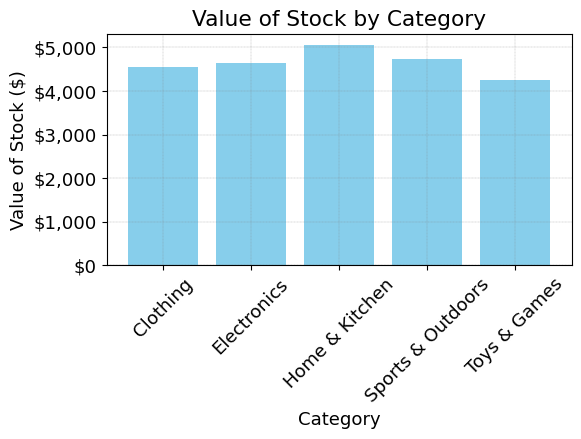

In [703]:
display(category_value_in_stock)


plt.figure(figsize=(6, 3))
# Create a bar plot
plt.bar(category_value_in_stock['Category'], category_value_in_stock['Value of Stock'], color='skyblue')

# Add the $ symbol to the y-axis labels
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Seting labels and title
plt.xlabel('Category')
plt.ylabel('Value of Stock ($)')
plt.title('Value of Stock by Category')
plt.xticks(rotation=45)
plt.grid(axis='both', color='gray', linestyle='--', linewidth=0.2) #grid


plt.show()


## Sales Analysis [Go There](#section4)



#### On the sales analysis I made more meaningful insight

- In my analysis of 2022's total sales across all stores, I created two types of charts: a line chart to visualize the sales in dollars and a bar chart for the quantities sold.


,Sale_Month,Quantity_Sold,Sales($)
0,Jan,732.0,208268.85
1,Feb,740.0,194153.23
2,Mar,863.0,234134.79
3,Apr,666.0,158625.69
4,May,827.0,218929.63
5,Jun,865.0,243218.64
6,Jul,962.0,253557.66


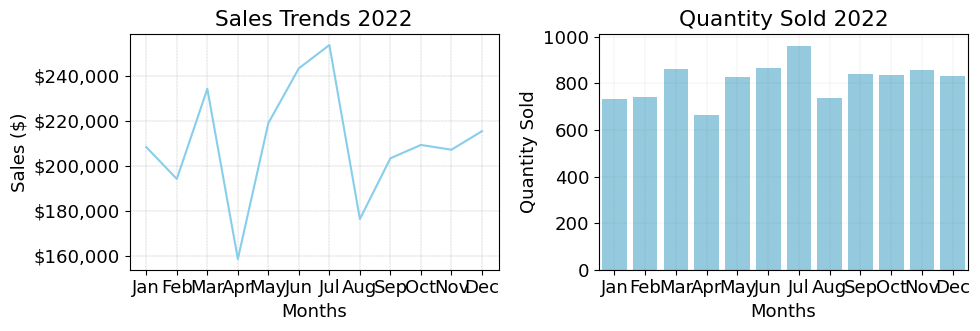

In [679]:
display(sales_trends.head(7))

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))  # 2 rows, 1 column

# First Subplot: Line Plot for Sales
sns.lineplot(ax=axes[0], data=sales_trends, x="Sale_Month", y="Sales($)", color='skyblue')
axes[0].yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axes[0].set_xlabel('Months')
axes[0].set_ylabel('Sales ($)')
axes[0].set_title('Sales Trends 2022')
axes[0].grid(axis='both', color='gray', linestyle='--', linewidth=0.2)

# Second Subplot: Bar Plot for Quantity Sold
sns.barplot(ax=axes[1], data=sales_trends, x="Sale_Month", y="Quantity_Sold", color='skyblue')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Quantity Sold')
axes[1].set_title('Quantity Sold 2022')
axes[1].grid(axis='both', color='gray', linestyle='--', linewidth=0.1)

# Display the plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()

### Conclusions
- The line plot clearly shows that April was the least successful month, with sales dipping to \$158,625.

- Conversely, July emerged as the top-performing month, witnessing a peak in sales at \$253,557.
- Additionally, the bar chart reveals a correlation between the quantity sold and the dollar value of sales. This is evident from the similar patterns observed in both charts.


### Using SQL queries I identified the top 20 sold products also their overall contribution to total revenue.


,Product_Name,Quantity_Sold,Total_Sales,Contribution_Percentage
0,Toy-Item 259,50.0,24067.50,0.954217
1,Kitchen-Tool 277,43.0,20265.04,0.803459
2,Toy-Item 449,40.0,19392.00,0.768845


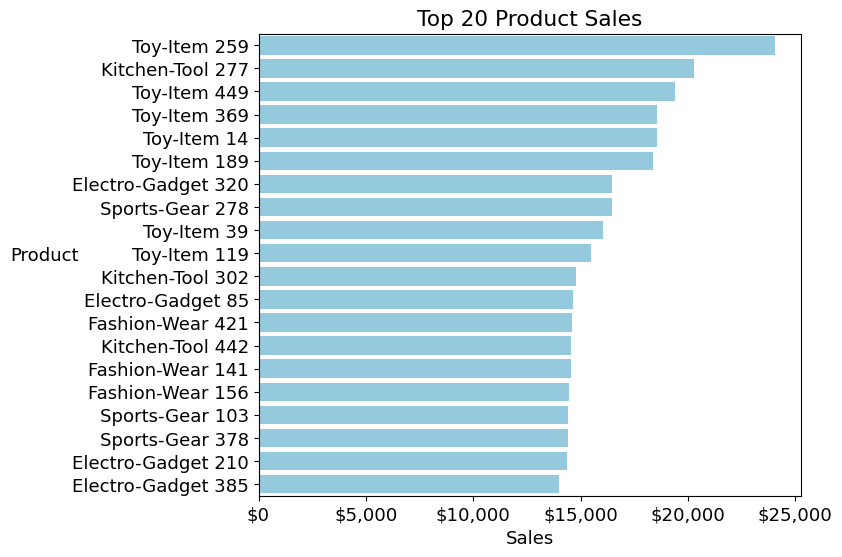

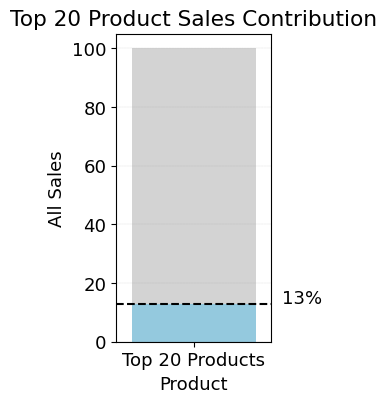

In [700]:
# overall_total_sales   # Total sales($) for all products
# top_20_sold           # Total sale table for top 20 products
# top_20_sales          # Sales of top 20 products in $
# top_20_contribution   # Contribution in % of top 20 in the overall revenue
 
# print(overall_total_sales)
# print(top_20_sold)
# print(top_20_sales)
# print(top_20_contribution)
display(top_20_sold.head(3))

plt.figure(figsize=(7,6))

ax = sns.barplot(data=top_20_sold, x="Total_Sales", y="Product_Name", color="skyblue")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda y, p: f'${y:,.0f}'))

ax.set_ylabel("Product", rotation=0, labelpad=20)

plt.xlabel("Sales")
plt.ylabel("Product")
plt.title("Top 20 Product Sales")  

plt.show()


plt.figure(figsize=(2, 4))

# Creating the barplot for the remaining percentage up to 100%
sns.barplot(x=["Top 20 Products"], y=[100], color="lightgray")

# Overlaying the barplot for the top 20 products contribution
sns.barplot(x=["Top 20 Products"], y=[top_20_contribution], color="skyblue")

# Adding labels and title
plt.xlabel("Product")
plt.ylabel("All Sales")
plt.title("Top 20 Product Sales Contribution")

# Drawing a line and adding annotation
plt.axhline(y=top_20_contribution, color='black', linestyle='--')
plt.text(x=0.7, y=top_20_contribution, s=f"13%", ha='center')
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.1)

# Show the plot
plt.show()



### Conclusions
#### Judging from the charts above, we can clearly identify the top three sold products:

- **Toy-Item 259**
  - Sold: 50 times
  - Revenue: \$24,067
  - Contribution to Sales: 0.9%

- **Kitchen-Tool 277**
  - Sold: 43 times
  - Revenue: \$20,265.04
  - Contribution to Sales: 0.8%

- **Toy-Item 449**
  - Sold: 40 times
  - Revenue: \$19,392.00
  - Contribution to Sales: 0.7%

#### Insights from the Second Bar Plot
The second bar plot illustrates that the top 20 most sold products, out of a total of 500, account for 13% of the total sales. This figure is significant, indicating that a small fraction ( 4%) of the products is contributing to a big portion of the sales, highlighting their importance in the overall sales strategy.


### The least 20 sold products are presneted on dataframe below showing their stocks level as well. 
- Here we can see not only the 20 least sold products but their stock reservess as well, potentially taking unesecary space, or need further investigation on why these products are having such a bad performance. 

In [573]:
# least_20_sold  -----Least 20 sold products recrods, including the stock reserves
display(least_20_sold.head(10))   

,Product_Name,Quantity_Sold,Total_Sales,Stock
0,Sports-Gear 43,0.0,0.0,76
1,Electro-Gadget 490,0.0,0.0,59
2,Sports-Gear 248,0.0,0.0,47
3,Electro-Gadget 255,0.0,0.0,89
4,Electro-Gadget 460,0.0,0.0,51
5,Fashion-Wear 371,0.0,0.0,12
6,Sports-Gear 333,0.0,0.0,55
7,Fashion-Wear 116,0.0,0.0,62
8,Sports-Gear 468,0.0,0.0,26
9,Electro-Gadget 40,0.0,0.0,50


## STORE PERFORMANCE [Go There](#section5)



### Store Sales Performance During 2022

,Store_Location,Quantity_Sold,Total_Sales
0,"Suburban Outlet, Los Angeles",2102.0,536803.46
1,"Downtown Store, New York",1971.0,510021.81
2,"Mall Branch, Chicago",1888.0,502105.35
3,"Online Shop, Phoenix",1921.0,492480.47
4,"Airport Kiosk, Houston",1822.0,467327.69


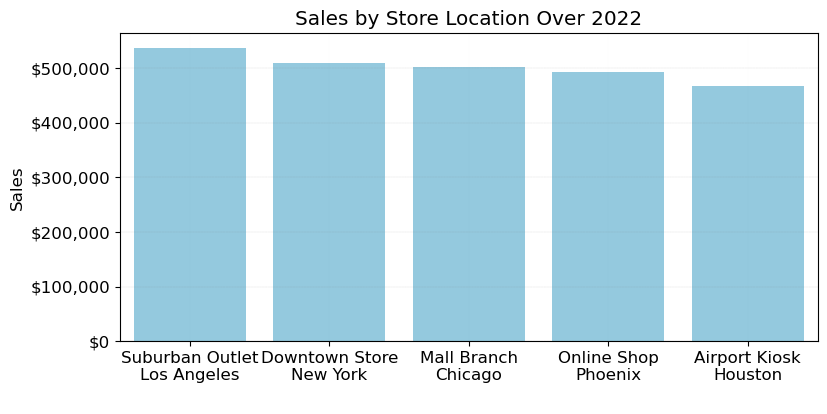

In [663]:

# Filter out the 'Unknown' location from the DataFrame
store_sales_filtered = store_sales[store_sales['Store_Location'] != 'Unknown']

display(store_sales_filtered)

# Create the bar plot with the filtered data
plt.figure(figsize=(9, 4))
sns.barplot(data=store_sales_filtered, x="Store_Location", y="Total_Sales", color="skyblue")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda y, p: f'${y:,.0f}'))

plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.01)
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.1)
plt.xlabel(" ")
plt.ylabel("Sales")
plt.title("Sales by Store Location Over 2022")

#Adding line breaks so the the x-axes ticks are not overwhelming with long text 
new_labels = [
    'Suburban Outlet\nLos Angeles', 
    'Downtown Store\nNew York', 
    'Mall Branch\nChicago', 
    'Online Shop\nPhoenix', 
    'Airport Kiosk\nHouston'
]

# Seting the new labels to the x-axis
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)  # Adjust rotation if needed

plt.show()


## Conclusions

- As observed from the chart above, the sales figures across different stores show relatively minor differences. \
However, we can pinpoint the "Suburban Outlet, Los Angeles" as the top performer, with the highest sales totaling \\$ 536,803 during 2022.
- Conversely, the "Airport Kiosk, Houston" recorded the lowest sales, amounting to \\$ 467,327.


## Identifying any stores with  different sales patterns.

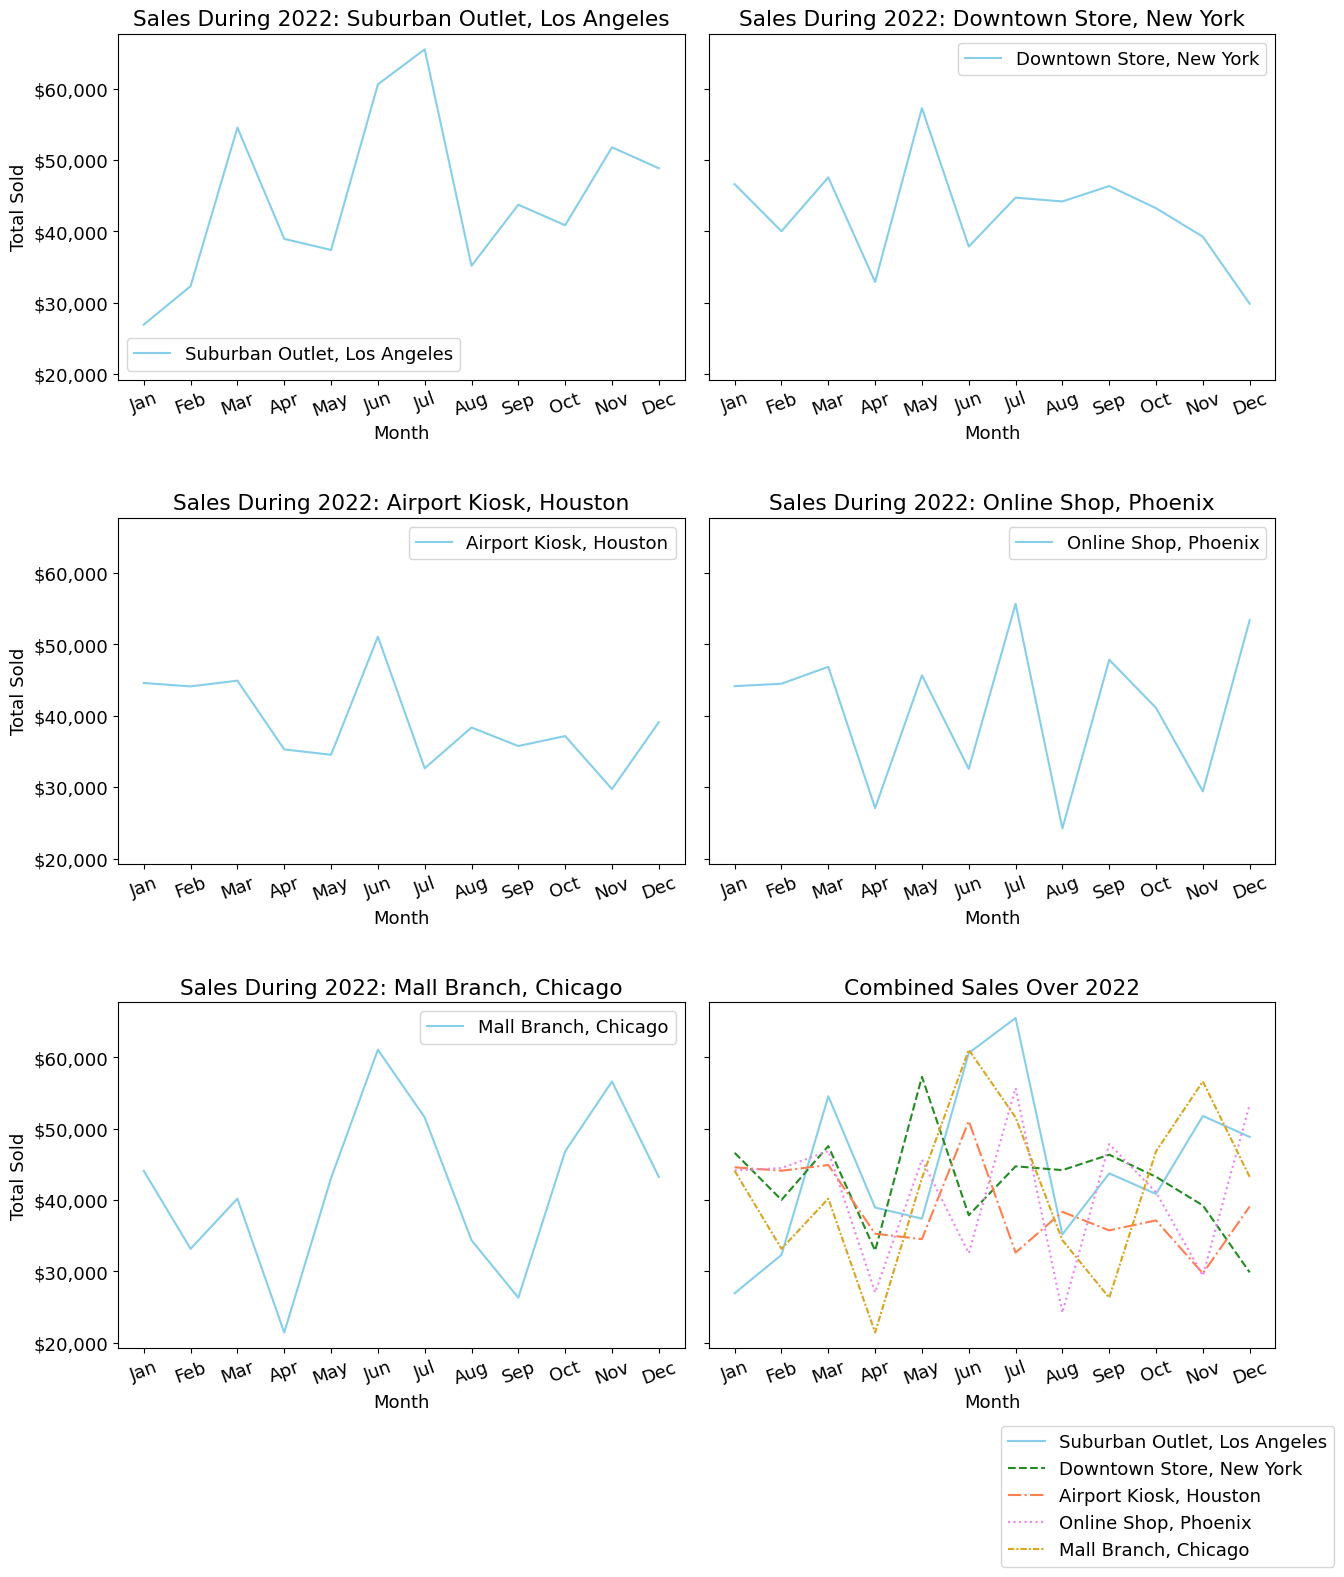

In [676]:
plt.rcParams.update({'font.size': 13})  # font size for all elements

store_sales_month_filtered = store_sales_month[store_sales_month['Store_Location'] != 'Unknown']
locations = store_sales_month_filtered['Store_Location'].unique()

colors = ['skyblue', 'forestgreen', 'coral', 'violet', 'goldenrod', 'tomato', 'mediumslateblue', 'limegreen', 'deeppink', 'darkorange']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (3, 5, 1, 5)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (3, 1, 1, 1, 1, 1))]


# Creating a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 16), sharey=True)
axs = axs.flatten()  # Flatten the array of axes for easy iteration no need for axs[0, 1].plot(...)

#Defining months so I can add it on the x-ticks for evrery subplot 
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Looping through the unique locations and creating a line plot for each
for i, location in enumerate(locations):
    # Filter data for each location
    data = store_sales_month_filtered[store_sales_month_filtered['Store_Location'] == location] #Extracting each month sale for each location for 1 year
                #ax=axs[i] decides the position of the subplot      #colors[i % len(colors)] linestyle=line_styles[i % len(line_styles)],
    sns.lineplot(ax=axs[i], data=data, x='Month', y='Total_Sales', color="skyblue",  label=location)
    axs[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'${y:,.0f}'))
    axs[i].set_xticks(range(len(month_labels)))
    axs[i].set_xticklabels(month_labels, rotation=20)
#     axs[i].fill_between(data['Month'], data['Total_Sales'], color="lightgrey", alpha=0.1) #This made comparison harder s
    axs[i].set_title(f'Sales During 2022: {location}')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Total Sold')
    axs[i].legend()

    
# Add the combined plot in the last subplot
if len(locations) <= len(axs):
    for i, location in enumerate(locations):
        # Filter data for each location
        data = store_sales_month_filtered[store_sales_month_filtered['Store_Location'] == location]
        sns.lineplot(ax=axs[-1], data=data, x='Month', y='Total_Sales', color=colors[i % len(colors)], linestyle=line_styles[i % len(line_styles)], label=location)
    
    axs[-1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'${y:,.0f}'))
    axs[-1].set_xticks(range(len(month_labels)))
    axs[-1].set_xticklabels(month_labels, rotation=20)
    axs[-1].set_title('Combined Sales Over 2022')
    axs[-1].set_xlabel('Month')
    axs[-1].set_ylabel('Total Sold')
    axs[-1].legend(loc='upper left', bbox_to_anchor=(0.5, -0.2)) 

# Clean look, and vertical spacing between the subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()


## Conclusion
- Across the stores, sales patterns during 2022 were relatively consistent. However, a notable exception was the "Downtown Store, New York," which experienced a noticeable decline in sales from September onwards.


## Note:
While working on this analysis, I noticed that the random nature of the data didn't make it the best fit for linear regression, or even for getting out very meaningful insights, also I can imagine the sales patterns in a retail setting can be heavily influenced by seasonal changes. 
However, I made the decision to complete this end-to-end project as it offered an opportunity to enhance my hands-on experience in data analysis and gain valuable insights into the process.